In [25]:
import sys
import pandas as pd
from pybaseball import statcast, cache
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
import numpy as np
from colorama import Fore
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [26]:
sc_data = statcast('2023-05-01', '2023-05-03')
# sc_data = sc_data[(sc_data['pitch_name'] != '4-Seam Fastball') | (sc_data['release_speed'] <= 96)]

This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


In [27]:
cols = ['release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_speed', 'pitch_name', 'p_throws', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az']
data = sc_data[cols]
sc_data.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [28]:
data['pitch_name'] = data['pitch_name'].replace({
    '4-Seam Fastball': 0,
    'Sinker': 10,
    'Cutter': 20,
    'Split-Finger': 30,
    'Slider': 40,
    'Curveball': 50,
    'Changeup': 60,
})

data['p_throws'] = data['p_throws'].replace({
    'R': 0,
    'L': 1
})

drop_columns = ['Sweeper', 'Screwball', 'Forkball', 'Slurve',
       'Other', 'Eephus', 'Slow Curve', 'Pitch Out', None, 'Knuckle Curve']
data = data[~data['pitch_name'].isin(drop_columns)]

data.pitch_name.unique()

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_13404\2917760446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pitch_name'] = data['pitch_name'].replace({
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_13404\2917760446.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['p_throws'] = data['p_throws'].replace({


array([50, 10, 60, 20, 40, 0, 30], dtype=object)

In [29]:
features = ['release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_speed', 'p_throws', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az']
X = data[features]
y = data.pitch_name


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [30]:
train_X, test_X, train_y, test_y = train_test_split(X, y_encoded, random_state=0)
model = XGBClassifier()
model.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

y_pred = model.predict(test_X)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(test_y, y_pred)
precision = precision_score(test_y, y_pred, average='weighted')
recall = recall_score(test_y, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy: {:.8f}".format(accuracy))
print("Precision: {:.8f}".format(precision))
print("Recall: {:.8f}".format(recall))

Accuracy: 0.91702884
Precision: 0.91638701
Recall: 0.91702884


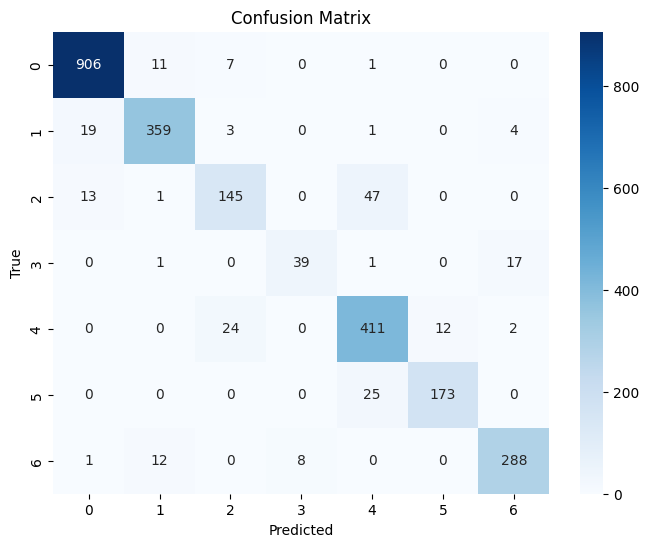

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(test_y, y_pred)

# Get class labels from unique values in test_y
class_labels = np.unique(test_y)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [33]:
df = pd.read_csv('test.csv')
df = df.rename(columns={'RelSpeed': 'release_speed', 'HorzBreak': 'pfx_x', 'VertBreak': 'pfx_z', 'SpinAxis': 'spin_axis',
                 'SpinRate': 'release_spin_rate', 'PitcherThrows': 'p_throws', 'az0': 'az', 'ay0': 'ay', 'ax0': 'ax'})
df['p_throws'] = df['p_throws'].replace({
    'Right': 0,
    'Left': 1
})

len(model.predict(df[features]))


243

In [35]:
from sklearn.model_selection import GridSearchCV


# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Create an instance of XGBClassifier
model = XGBClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(train_X, train_y)

# Retrieve the best parameters
best_params = grid_search.best_params_
print(best_params)


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
